In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import glob

In [2]:
# pd.read_csv made some mistakes when reading the tsv files
# this function is able to read the files more reliably
def read_csv(path, sep= ',', names=["PAGENAME", "OCR", "GT"]):
    with open(path, 'r', encoding='utf8') as file:
        rows = file.read().split("\n")
        data = np.array([row.split(sep) for row in rows if len(row.split(sep)) == 3])
    return pd.DataFrame(data=data, columns=names)

In [3]:
ocr_file_0 = "../ocr_data/nlf_ocr_gt_tescomb5_2017.xlsx"
path = '../ocr_data/'
folders = [f for f in glob.glob(path + "**/*.tsv", recursive=True)] 
folders

['../ocr_data\\test1-id-ocr-gt.tsv',
 '../ocr_data\\test2-id-ocr-gt.tsv',
 '../ocr_data\\test3-id-ocr-gt.tsv',
 '../ocr_data\\test4-id-ocr-gt.tsv',
 '../ocr_data\\test5-id-ocr-gt.tsv']

In [4]:
df_sampled = pd.concat([read_csv(path, sep = "\t", names=["PAGENAME", "OCR", "GT"]) for path in folders])
df_sampled.head()

,PAGENAME,OCR,GT
0,0001-5636_1938_43__P484_TL00029,yksityisten henkilöiden viljeltäviksi ja asutt...,yksityisten henkilöiden viljeltäviksi ja asutt...
1,0003-7184_1933_2__P15_TL00103,"Mieheni ei tarvitse apua. Odota,","Mieheni ei tarvitse apua. Odota,"
2,0003-7184_1933_37__P11_TL00188,kiinnostuneena jo tuolla sisällä.,kiinnostuneena jo tuolla sisällä.
3,0013-6522_1927-03_3__P27_TL00080,"ne kerhot, jotka nyt niin vähän elon merk-","ne kerhot, jotka nyt niin vähän elon merk-"
4,0013-6522_1927-09_9__P26_TL00061,"jolloin lepäsit kotirannalla ennen, ja siskot","jolloin lepäsit kotirannalla ennen, ja siskot"


In [5]:
# reading the excel file takes a while
df_full = pd.read_excel(ocr_file_0, sheet_name="Words", header=3, skip_rows=[0,1,2])
df_full.head()

,PUBTYPE,PUBYEAR,ISSN,PAGENAME,SORTORDER,GT,TESSERACT,OLD,FR11,TESCOMB_EQ,OLD_EQ,FR11_EQ,TESCOMB_MATCH,OLD_MATCH,FR11_MATCH
0,AIK,1884,fk00010,fk00010_1884-12-09_0_8,1,N:o,NaN,M:c>,Hl:c>,0,0,0,0,1,1
1,AIK,1884,fk00010,fk00010_1884-12-09_0_8,2,0.,NaN,0.,O.,0,1,0,0,1,1
2,AIK,1884,fk00010,fk00010_1884-12-09_0_8,3,taan,taan,taan,taan,1,1,1,1,1,1
3,AIK,1884,fk00010,fk00010_1884-12-09_0_8,4,sekä,sekä,sekä,sekä,1,1,1,1,1,1
4,AIK,1884,fk00010,fk00010_1884-12-09_0_8,5,ehdottomasti,ehdottomasti,ehdottomasti,ehdottomasti,1,1,1,1,1,1


In [6]:
ground_truth = df_full.values[:,5].astype(np.str)
ocr_tess = df_full.values[:,6].astype(np.str)
ocr_old = df_full.values[:,7].astype(np.str)
ocr_fr11 = df_full.values[:,8].astype(np.str)
ocr_sampled = df_sampled.values[:,1].astype(np.str)
gt_sampled = df_sampled.values[:,2].astype(np.str)

In [7]:
# join the individual words into pages
def join(array):
    return " ".join(map(str, array))
def combine_to_pages(dataframe, column):
    pages = np.split(dataframe.values[:, column], np.cumsum(np.unique(dataframe.values[:, 3], return_counts=True)[1])[:-1])
    return np.array(list(map(join, pages)))
pages_gt = combine_to_pages(df_full, 5)
pages_tess = combine_to_pages(df_full, 6)
pages_old = combine_to_pages(df_full, 7)
pages_fr11 = combine_to_pages(df_full, 8)
ocr_sampled = df_sampled.values[:,1]
pages_gt[1]

'että kunnille sallittaisiin walta sulkea kapakat alueellaan, mutta wielä ei ole semmoinen laki tullut toimeen. Parlamentti on tosin kerran hywäksynyt tätä asiaa periaatteena, mutta periaatteesta käytäntöön näyttää olewan koko pitkä tie. Nykyhetkenä wallitsee waltakunnassa kiihkeä taistelu muutettawasta waalilaista, joka tempaa puoleensa kaikkien huomion ja työntää syrjään raittiusasian, ja sen ohessa on ollut ja on muitakin asioita, joilla on koetettu ja onnistuttu sekoittaa pois waltiopäiwämiesten mielet kun raittiusasia on nostettu puheeksi; mutta sillä wälin waan juurtuwat raittiuden periaatteet sywemmin kansassa, niin että kun kerran asia todellakin otetaan puheeksi, kaiketi woidaan toiwoa paljon hywää raittiusasialle. Ja woitto Englannissa ei olisi woitto Englannille yksistään, se esimerkki waikuttaisi laajalle ympäri maailman. — Wenäjän aloja kuwaawa on tapaus, jonka "Inkeri" kertoo, Kauppias Makarowilla oli eräässä seurakunnassa ollut kaksi kapakkaa. Saadakseen seurakuntalaiste

In [8]:
np.mean(ocr_sampled==gt_sampled)

0.596439566323116

In [9]:
def word_align(ocr, truth):
    #compute lehvenstein stuff but return an array of
    # 1,x,x,x if correct letter
    # x,1,x,x if different letter
    # x,x,1,x if missing letter
    # x,x,x,1 if extra letter
    words = len(truth.split())
    m = len(ocr)
    n = len(truth)
    d = np.zeros([n+1, m+1], np.int)
    path = np.zeros([n+1, m+1], np.int)
    path[0,0] = 2
    for i in range(1, n+1):
        d[i, 0] = i
        path[i, 0] = 1
    for j in range(1, m+1):
        d[0, j] = j
        path[0, j] = 0
    for j in range(1, m+1):
        for i in range(1, n+1):
            substitutionCost = 1-(truth[i-1] == ocr[j-1])*1
            choices = [ d[i-1, j] + 1,                   # deletion
                        d[i, j-1] + 1,                   # insertion
                        d[i-1, j-1] + substitutionCost]  # substitution
            min_choice = np.argmin(choices)
            
            path[i, j] = min_choice
            d[i, j] = choices[min_choice]
    i = n
    w = words-1
    res = np.zeros([words+1], np.int)
    res[words] = len(ocr)
    for j in range(m, -1, -1):
        prev = -1
        while prev <= 0:
            prev = path[i, j]
            if prev == 0: #deletion
                if i<1 or truth[i-1] == ' ':
                    res[w] = j
                    w -= 1
                    w = max(w, 0)
                i -= 1
            elif prev == 1: #insertion
                pass
            elif prev == 2: #substitution
                if i<1 or truth[i-1] == ' ':
                    res[w] = j
                    w -= 1
                    w = max(w, 0)
                i -= 1
    return res
def vector_word_align(ocr, gt): #np.vectorize(lehvenstein_differences, signature='()->(n)')
    assert(len(ocr)==len(gt))
    return np.array([word_align(ocr[i], gt[i]) for i in range(len(ocr))])
    

In [10]:
sampled_word_boundaries = vector_word_align(ocr_sampled, gt_sampled)

In [11]:
sampled_words = [[ocr_sampled[ind][sampled_word_boundaries[ind][i]:sampled_word_boundaries[ind][i+1]].strip() for i in range(len(sampled_word_boundaries[ind])-1)] for ind in range(len(sampled_word_boundaries))]
print(sampled_words[50])
print(gt_sampled[50])

['seen,', 'miel.', 'saaan', 'paikkaan.', 'Vas-']
seen, miel. samaan paikkaan. Vas-


In [12]:
# the uniformly selected data aligned to word level
ocr_sampled_words = np.concatenate(sampled_words)
gt_sampled_words = np.concatenate([sentence.split() for sentence in gt_sampled])
print(len(gt_sampled_words), len(ocr_sampled_words))

46902 46902


In [13]:
# word level accuracy
print(np.mean(gt_sampled_words == ocr_sampled_words))

0.8890878853780223


In [14]:
# average number of words per row
np.mean([len(sent.split()) for sent in gt_sampled])

6.277874447865078

In [15]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1] #/ (1.0*len(s2))  
vectorLehvenstein = np.vectorize(levenshteinDistance)

In [16]:
lehv_distances = vectorLehvenstein(ocr_sampled, gt_sampled)
worst_rows = np.argsort(lehv_distances)
# print some of the worst ocr mistakes in the dataset based on edit distance
print(levenshteinDistance(ocr_sampled[worst_rows[-1]], gt_sampled[worst_rows[-1]]))
ocr_sampled[worst_rows[-10:]], gt_sampled[worst_rows[-10:]]

69


(array(['leian aoss nsmen nrene ier fndetsage ie iler',
        'nöpi Nidord, ser Hw öxprs Kob, kaskd i',
        'Guon afadla amdlen soen apiomen an å ho',
        'ler amiölas am simiatar 8ör dddrdn mäka',
        'Höteaman nsann a n t enrdn isdenemar oö-', 'Tätttmt stigsäa',
        'Fmentareei hiensrs inderräreise eäked has Herr Haudetsmaa äkr älngrt, öo sureionsg',
        'gr stnsilt e diri smin Åi äni srde fken',
        'Återbetalte insatser för 16 med döden afgångne delegare ................ ,, 2,004:',
        'till Åbo .............................................................. 23 20 — 12 50 8 50'],
       dtype=object),
 array(['laså har gräswerten, som icke städats af is eller',
        'RÖDE MÄNNEN, eller HIN ONDES SON, skådespel i 5',
        'Genom offentlig auktion, som onsdagen den 25 inne-',
        'let ansökas inom femtiosex (56) dagar härefter, denna da',
        'sande på engång afstå all sin egendom och derefter med',
        'nar; 65 äro engelska och destine

7471

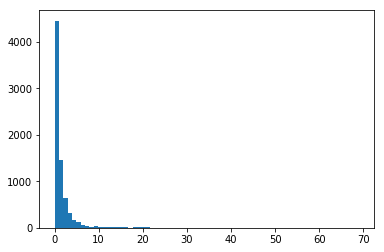

In [17]:
# most of the errors are only one or two characters in the row
plt.hist(lehv_distances, bins=70)
len(lehv_distances)

In [18]:
#Create bigrams
bgs_old = nltk.bigrams(" ".join(pages_old))
bgs_tess = nltk.bigrams(" ".join(pages_tess))
bgs_fr11 = nltk.bigrams(" ".join(pages_fr11))
bgs_gt = nltk.bigrams(" ".join(pages_gt))

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs_gt)

def freq_cmp(a):
    return a[1]
def printable_bigram_freqs(freq):
    k, v = freq
    return "".join(k)+" "+str(v)
", ".join(map(printable_bigram_freqs, sorted(list(fdist.items()), key=freq_cmp, reverse=True)))

'n  124402, a  93627, ta 66964, en 63141, in 62363, an 55692, is 52213,  k 49491, .  46782, st 46689, ä  45465, si 43948, ,  42123, ll 41736, tt 41731, aa 41633, i  39189,  s 38639, ka 38062, tä 37537, se 36892,  t 36714, sa 35163,  j 35156, it 34280, wa 32156, ai 31331,  o 30971, et 29847, ja 29582,  w 29084, la 29057,  m 28603,  p 28437, li 28064, al 27518, te 27512, el 27353, t  26537, tu 25696, on 25586, oi 25418, ma 25260, le 24762, än 24655, ti 23403, as 22998, ss 22466, at 22452, ku 22441, ki 22385,  e 21750, ne 21734, il 21370, ks 21264, mi 21183, ii 20765, ol 20752, ko 20735, ut 20478, e  20179,  h 19897, un 19235, ik 19074, es 18493, ää 17918, uu 17556, to 17467, ei 17467, uo 17278, jo 16781, ar 16738, ee 16317,  l 16217, na 15932,  a 15777, me 15674, us 15468, ke 15391,  n 15288, ni 15127, ri 14881, er 14780, nn 14672, lä 14384, ul 14245, ra 14023, nt 13996, ie 13968, ak 13402, wi 12998, pa 12947, uk 12581, os 12459, ns 12425, a, 12278, sä 12113, de 11987, ot 11966, lu 11741